In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import databento  # Assuming you have installed the Datab
from dotenv import load_dotenv
import os
load_dotenv()
# Set up API key and create client
API_KEY = os.getenv('API_KEY') # Replace with your API key
client = databento.Historical(key=API_KEY)
# Set up parameters
instrument = 'AAPL'  # Example: Apple stock
start_date = '2023-10-25'
end_date = '2024-10-25'
dataset = 'XNAS.ITCH'
schema = 'OHLCV-1d'

print(client.metadata.get_dataset_range('XNAS.ITCH'))
# Get historical data
data = client.timeseries.get_range(
    symbols=instrument,
    start=start_date,
    end=end_date,
    dataset=dataset,
    schema=schema
    # fields=['date', 'close']
)
# Convert data to DataFrame
df = data.to_df()  # to DataFrame

{'start': '2018-05-01T00:00:00.000000000Z', 'end': '2024-10-25T00:00:00.000000000Z'}


In [44]:
df.sort_index(inplace=True)
df['close']

ts_event
2023-10-25 00:00:00+00:00    169.30
2023-10-26 00:00:00+00:00    167.00
2023-10-27 00:00:00+00:00    168.02
2023-10-30 00:00:00+00:00    169.79
2023-10-31 00:00:00+00:00    170.25
                              ...  
2024-10-18 00:00:00+00:00    234.85
2024-10-21 00:00:00+00:00    236.52
2024-10-22 00:00:00+00:00    235.60
2024-10-23 00:00:00+00:00    230.47
2024-10-24 00:00:00+00:00    229.50
Name: close, Length: 252, dtype: float64

In [47]:
# Set up simulation parameters
# Setup parameters
S0 = df['close'].iloc[-1]  # Current stock price
K = 150                    # Strike price (for options)
r = 0.015                  # Risk-free rate (1.5%)
sigma = 0.25               # Volatility (25%)
T = 1.0                    # Time horizon (1 year)
N = 252                    # Number of trading days
dt = T / N                 # Time step size
M = 10000                  # Number of simulation paths

def simulate_gbm(S0, r, sigma, T, N, M):
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        # Corrected formula: Added the missing volatility term
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S
S = simulate_gbm(S0, r, sigma, T, N, M)
S

array([[229.5       , 229.5       , 229.5       , ..., 229.5       ,
        229.5       , 229.5       ],
       [223.86732623, 231.15233784, 234.14592055, ..., 232.43653095,
        227.11451352, 230.82134998],
       [226.09553816, 232.77305523, 235.86826567, ..., 234.81602289,
        226.0235015 , 232.15910116],
       ...,
       [215.58098445, 140.69544911, 192.36162186, ..., 194.6105842 ,
        252.59124494, 318.55498608],
       [220.74166056, 135.8388183 , 192.17173694, ..., 194.31262795,
        244.79630007, 321.63641704],
       [213.31149987, 138.06602108, 188.24858088, ..., 196.24141062,
        243.13834298, 320.5200282 ]])

In [46]:
S

array([[229.5       , 229.5       , 229.5       , ..., 229.5       ,
        229.5       , 229.5       ],
       [229.48520137, 229.48520137, 229.48520137, ..., 229.48520137,
        229.48520137, 229.48520137],
       [229.47040369, 229.47040369, 229.47040369, ..., 229.47040369,
        229.47040369, 229.47040369],
       ...,
       [225.82988571, 225.82988571, 225.82988571, ..., 225.82988571,
        225.82988571, 225.82988571],
       [225.81532374, 225.81532374, 225.81532374, ..., 225.81532374,
        225.81532374, 225.81532374],
       [225.80076271, 225.80076271, 225.80076271, ..., 225.80076271,
        225.80076271, 225.80076271]])

In [48]:
# Calculate payoff at maturity for call option
payoff = np.maximum(S[-1] - K, 0)
option_price = np.exp(-r * T) * np.mean(payoff)
print(f"European call option price: {option_price:.2f}")

European call option price: 82.47


In [50]:
from scipy.stats import qmc, norm
def simulate_gbm_sobol(S0, r, sigma, T, N, M):
    # Create Sobol sequence generator
    sampler = qmc.Sobol(d=N, scramble=True)
    
    # Generate Sobol sequences (must be power of 2)
    sample = sampler.random_base2(m=int(np.log2(M)))
    
    # Transform uniform Sobol sequences to normal distribution
    Z = norm.ppf(sample).T
    
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0] = S0
    
    for t in range(1, N + 1):
        # Small issue: Z[t-1] should be used instead of Z
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
    return S

# Number of simulations must be power of 2 for Sobol sequences
M = 2**14  # 16384 simulations
S_sobol = simulate_gbm_sobol(S0, r, sigma, T, N, M)

In [51]:
S_sobol

array([[229.5       , 229.5       , 229.5       , ..., 229.5       ,
        229.5       , 229.5       ],
       [228.2143197 , 233.28456457, 231.5401057 , ..., 231.53979147,
        233.28605134, 228.2152087 ],
       [221.87518238, 234.37532401, 230.35288022, ..., 232.25421488,
        231.71301567, 230.74530826],
       ...,
       [186.8592985 , 198.83700552, 287.26760269, ..., 251.45902726,
        203.74040925, 276.83428785],
       [185.92605339, 200.08988381, 282.83849126, ..., 258.66714007,
        203.45642916, 279.71966435],
       [186.04260265, 198.90362392, 277.966437  , ..., 262.29319482,
        204.75120651, 279.30018564]])

In [52]:
def simulate_gbm_milstein(S0, r, sigma, T, N, M):
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0] = S0
    
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        # Milstein scheme formula:
        S[t] = S[t-1] + r*S[t-1]*dt + sigma*S[t-1]*np.sqrt(dt)*Z + \
               0.5*sigma**2*S[t-1]*(Z**2 - 1)*dt
    return S

# Run simulation
S_milstein = simulate_gbm_milstein(S0, r, sigma, T, N, M)

In [53]:
def price_american_option_lsm(S, K, r, T, N):
    dt = T / N
    payoff = np.maximum(K - S, 0)  # Put option payoff
    cash_flow = np.zeros_like(payoff)
    cash_flow[-1] = payoff[-1]  # Terminal payoff

    # Backward iteration through time steps
    for t in range(N - 1, 0, -1):
        # Find in-the-money paths
        itm = payoff[t] > 0
        
        if not np.any(itm):
            continue
            
        # Regression for continuation value
        X = S[t, itm]
        Y = cash_flow[t + 1, itm] * np.exp(-r * dt)
        
        # Basis functions (1, X, X^2)
        A = np.vstack([np.ones_like(X), X, X**2]).T
        
        # Solve least squares regression
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        
        # Calculate continuation value
        continuation_value = coeffs[0] + coeffs[1] * X + coeffs[2] * X**2
        
        # Exercise decision
        exercise = payoff[t, itm] > continuation_value
        
        # Update cash flows
        cash_flow[t, itm] = np.where(exercise, 
                                    payoff[t, itm], 
                                    cash_flow[t + 1, itm] * np.exp(-r * dt))
        
        # Discount future cash flows where not exercising
        cash_flow[t + 1, itm] = np.where(exercise, 
                                        0, 
                                        cash_flow[t + 1, itm])

    # Calculate option price
    option_price = np.mean(cash_flow[1] * np.exp(-r * dt))
    return option_price

# Use simulation and price option
S = simulate_gbm(S0, r, sigma, T, N, M)
option_price_lsm = price_american_option_lsm(S, K, r, T, N)
print(f"American-style option price using LSM: {option_price_lsm:.4f}")

American-style option price using LSM: 0.0000


In [54]:
from joblib import Parallel, delayed
def lsm_simulation_chunk(chunk_size, S0, K, r, sigma, T, N):
    """Simulate and price options for a chunk of paths"""
    S_chunk = simulate_gbm(S0, r, sigma, T, N, chunk_size)
    option_price_chunk = price_american_option_lsm(S_chunk, K, r, T, N)
    return option_price_chunk
total_simulations = 100000
num_cores = 4  # Number of CPU cores
chunk_size = total_simulations // num_cores

results = Parallel(n_jobs=num_cores)(
    delayed(lsm_simulation_chunk)(chunk_size, S0, K, r, sigma, T, N) 
    for _ in range(num_cores)
)

option_price_parallel = np.mean(results)
print(f"American-style put option price: {option_price_parallel:.4f}")

American-style put option price: 0.0000


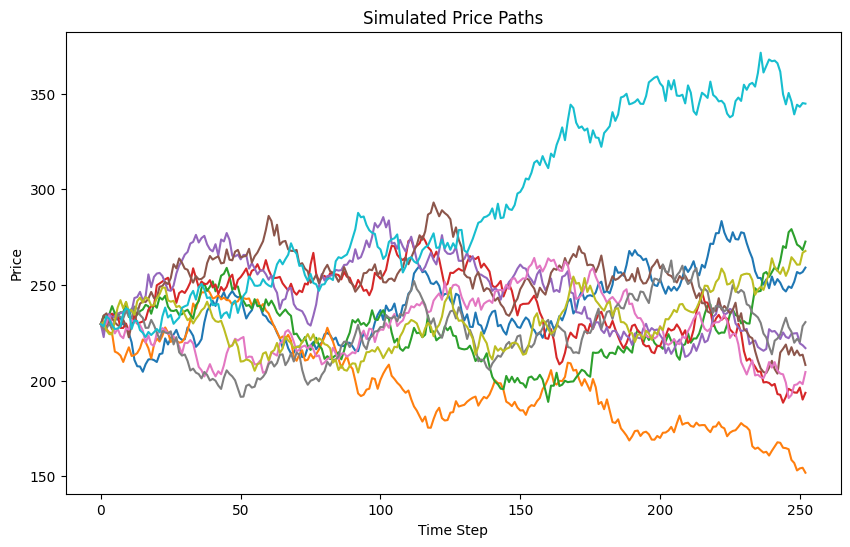

In [55]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(S[:, i])
plt.title('Simulated Price Paths')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.show()